In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
TRAIN_DIR = "DATASET/train"
TEST_DIR = "DATASET/test"

In [4]:
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image, label

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",  # One-hot labels for 7 classes
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
).map(preprocess)

print("Training dataset loaded:")
print(train_dataset)

Found 12271 files belonging to 7 classes.
Training dataset loaded:
<MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>


In [5]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

Batch shape: (32, 128, 128, 3)
Label sample: [0. 0. 0. 1. 0. 0. 0.]


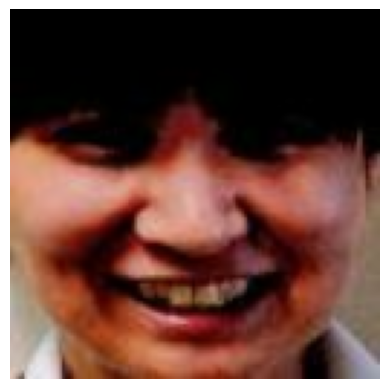

In [6]:
for images, labels in train_dataset.take(1):
    print("Batch shape:", images.shape)
    print("Label sample:", labels.numpy()[0])  # Print one-hot label
    plt.imshow((images[0].numpy() + 1) / 2)  # Convert back to [0,1] for display
    plt.axis("off")
    plt.show()

In [7]:
def build_generator():
    noise_input = tf.keras.layers.Input(shape=(100,))
    label_input = tf.keras.layers.Input(shape=(7,))

    # Merge noise and label
    merged_input = tf.keras.layers.Concatenate()([noise_input, label_input])

    x = tf.keras.layers.Dense(8 * 8 * 512, activation="relu")(merged_input)
    x = tf.keras.layers.Reshape((8, 8, 512))(x)

    x = tf.keras.layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding="same", activation="tanh")(x)

    generator = tf.keras.models.Model([noise_input, label_input], x, name="Generator")
    return generator

generator = build_generator()
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 107)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 32768)        3538944     ['concatenate[0][0]']    

In [8]:
def build_discriminator():
    image_input = tf.keras.layers.Input(shape=(128, 128, 3))
    label_input = tf.keras.layers.Input(shape=(7,))

    # Expand label to match image shape
    label_embedding = tf.keras.layers.Dense(128 * 128 * 1)(label_input)
    label_embedding = tf.keras.layers.Reshape((128, 128, 1))(label_embedding)

    # Merge image and label
    merged_input = tf.keras.layers.Concatenate()([image_input, label_embedding])

    x = tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding="same", activation="leaky_relu")(merged_input)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same", activation="leaky_relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(256, (5,5), strides=(2,2), padding="same", activation="leaky_relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)  # No sigmoid for WGAN

    discriminator = tf.keras.models.Model([image_input, label_input], x, name="Discriminator")
    return discriminator

discriminator = build_discriminator()
discriminator.summary()


Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 16384)        131072      ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 reshape_1 (Reshape)            (None, 128, 128, 1)  0           ['dense_1[0][0]']    

In [9]:
def wgan_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

def gradient_penalty(discriminator, real_images, fake_images, labels):
    alpha = tf.random.uniform([real_images.shape[0], 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator([interpolated, labels], training=True)

    grads = gp_tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
    return tf.reduce_mean((norm - 1.0) ** 2)

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)


In [10]:
@tf.function
def train_step(real_images, labels):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape(persistent=True) as tape:
        fake_images = generator([noise, labels], training=True)

        real_output = discriminator([real_images, labels], training=True)
        fake_output = discriminator([fake_images, labels], training=True)

        d_loss_real = wgan_loss(tf.ones_like(real_output), real_output)
        d_loss_fake = wgan_loss(-tf.ones_like(fake_output), fake_output)
        gp = gradient_penalty(discriminator, real_images, fake_images, labels)

        d_loss = d_loss_real + d_loss_fake + 10.0 * gp
        g_loss = wgan_loss(tf.ones_like(fake_output), fake_output)

    d_gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    g_gradients = tape.gradient(g_loss, generator.trainable_variables)

    disc_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    gen_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

    return g_loss, d_loss


In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

# Define checkpoint directory
checkpoint_dir = "./checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a checkpoint object
# checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator,
#                                  gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer)
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator,
                                 gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer,
                                 epoch=tf.Variable(0, dtype=tf.int64))

def restore_checkpoint():
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        status = checkpoint.restore(latest_checkpoint)
        status.expect_partial()  # Optional: silence warnings for missing variables
        start_epoch = int(checkpoint.epoch.numpy())
        print(f"Checkpoint restored successfully. Resuming from epoch {start_epoch}.")
        return start_epoch
    else:
        print("No checkpoint found. Training from scratch, starting at epoch 0")
        return 0

# Loss tracking for plotting
gen_losses, disc_losses = [], []

def train(dataset, epochs,start_epoch):
    for epoch in range(start_epoch, epochs):
        start_time = time.time()
        g_loss_avg, d_loss_avg = 0, 0

        for real_images, labels in dataset:
            g_loss, d_loss = train_step(real_images, labels)
            g_loss_avg += g_loss.numpy()
            d_loss_avg += d_loss.numpy()

        g_loss_avg /= len(dataset)
        d_loss_avg /= len(dataset)

        # Store loss values for plotting
        gen_losses.append(g_loss_avg)
        disc_losses.append(d_loss_avg)

        print(f"Epoch {epoch+1}/{epochs}, Gen Loss: {g_loss_avg:.4f}, Disc Loss: {d_loss_avg:.4f}, Time: {time.time()-start_time:.2f}s")

        # Generate a sample every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_sample(epoch + 1)

        # Save model checkpoints every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved at epoch {epoch+1}")

        # Plot loss curve every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_loss_curve()

def generate_sample(epoch):
    noise = tf.random.normal([1, 100])
    label = tf.one_hot([np.random.randint(0,7)], depth=7)

    fake_image = generator([noise, label], training=False)
    fake_image = (fake_image[0] + 1) / 2  # Normalize to [0,1]

    plt.imshow(fake_image)
    plt.axis("off")
    plt.savefig(f"sample_epoch_{epoch}.png")
    plt.close()
    print(f"Sample image saved at epoch {epoch}")

def plot_loss_curve():
    plt.figure(figsize=(8, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("GAN Training Loss")
    plt.savefig("gan_training_loss.png")
    plt.close()
    print("Loss curve updated.")

# Restore the latest checkpoint if available
if tf.train.latest_checkpoint(checkpoint_dir):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print("Checkpoint restored!")

start_epoch = restore_checkpoint()
# Start training
train(train_dataset, epochs=1000,start_epoch=start_epoch)

Checkpoint restored!


AttributeError: 'Checkpoint' object has no attribute 'epoch'

In [44]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def interpolate_images(generator, latent_dim=100, num_classes=7, num_interpolations=10):
    # Generate two random latent vectors
    z1 = tf.random.normal([1, latent_dim])
    z2 = tf.random.normal([1, latent_dim])

    # Generate a random class label
    label_index = np.random.randint(0, num_classes, size=(1,))
    label = tf.one_hot(label_index, depth=num_classes)

    # Set up the plot
    fig, axes = plt.subplots(1, num_interpolations, figsize=(20, 5))

    # Generate interpolated images
    for i, alpha in enumerate(np.linspace(0, 1, num_interpolations)):
        z = (1 - alpha) * z1 + alpha * z2
        try:
            fake_image = generator([z, label], training=False)
            fake_image = (fake_image[0].numpy() + 1) / 2  # Normalize to [0,1]
            axes[i].imshow(fake_image)
            axes[i].axis("off")
            axes[i].set_title(f"Alpha: {alpha:.2f}")
        except Exception as e:
            print(f"Error generating image at alpha {alpha:.2f}: {e}")
            axes[i].axis("off")
            axes[i].set_title(f"Error at alpha {alpha:.2f}")

    plt.show()


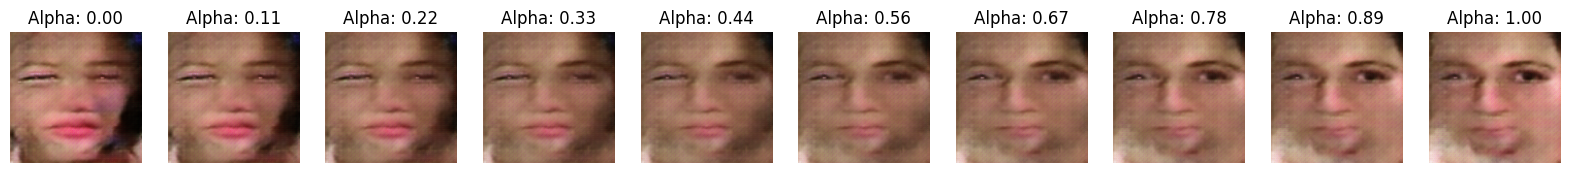

In [45]:
# Assuming 'generator' is your trained generator model
interpolate_images(generator)


Checkpoint restored!


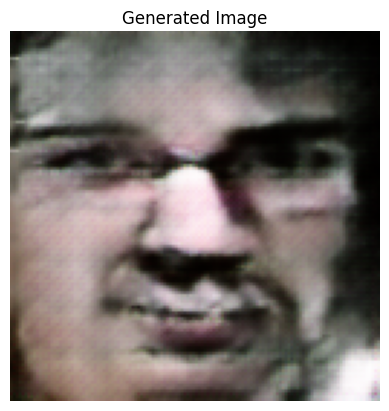

In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the latest checkpoint
checkpoint_dir = "./checkpoints"
checkpoint = tf.train.Checkpoint(generator=generator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()
print("Checkpoint restored!")

def generate_test_image():
    noise = tf.random.normal([1, 100])  # Random latent vector
    label = tf.one_hot([np.random.randint(0, 7)], depth=7)  # Random attribute label

    fake_image = generator([noise, label], training=False)
    fake_image = (fake_image[0] + 1) / 2  # Normalize to [0,1] for visualization

    plt.imshow(fake_image)
    plt.axis("off")
    plt.title("Generated Image")
    plt.show()

# Run inference
generate_test_image()


In [ ]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl (11.2 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


In [48]:
!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


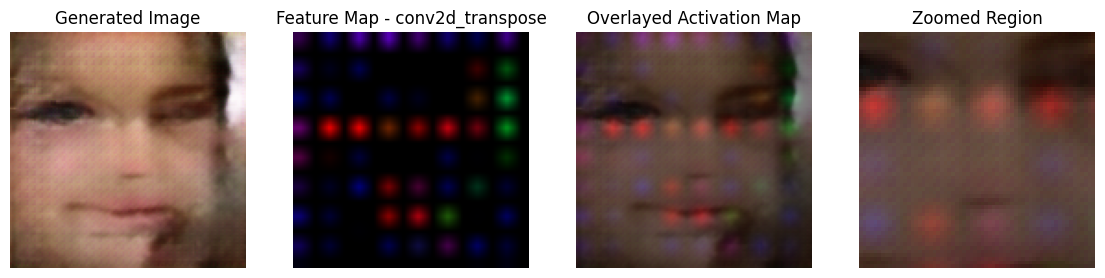

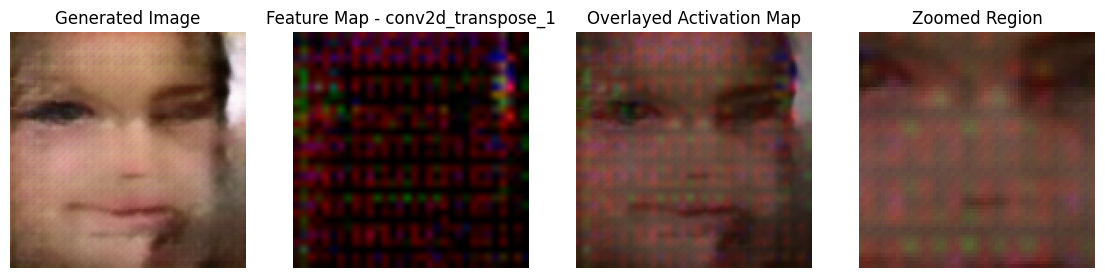

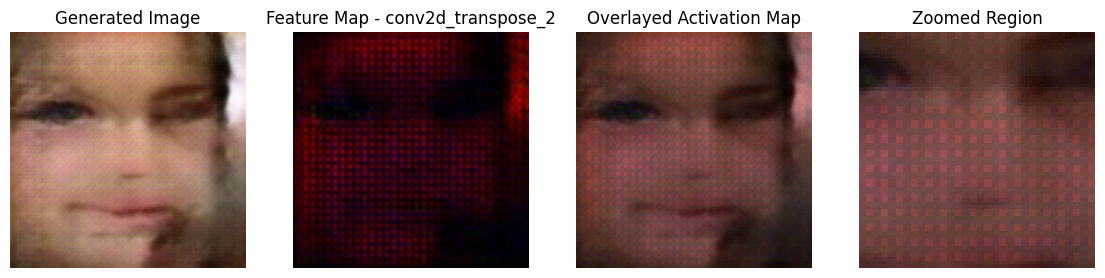

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define function to visualize generator activations with color mapping
def visualize_generator_activations(generator, layer_names):
    """Visualizes feature maps with color mapping & overlays on generated images."""
    
    # Create models that output activations from selected layers
    intermediate_models = [tf.keras.Model(inputs=generator.input, 
                                          outputs=generator.get_layer(name).output) 
                           for name in layer_names]

    # Generate test input
    noise = tf.random.normal([1, 100])
    label = tf.one_hot([np.random.randint(0, 7)], depth=7)  # Random label
    
    # Generate image from generator
    generated_image = generator([noise, label], training=False)[0].numpy()
    generated_image = (generated_image + 1) / 2  # Normalize to [0,1]

    # Iterate through selected layers
    for model, layer_name in zip(intermediate_models, layer_names):
        activations = model([noise, label], training=False)
        activations = activations[0].numpy()  # Extract feature maps

        num_features = min(3, activations.shape[-1])  # Use 3 for RGB-like visualization
        
        # Combine first 3 feature maps into an RGB image
        activation_map = np.zeros_like(activations[:, :, :3])
        for i in range(num_features):
            activation_map[:, :, i] = activations[:, :, i]

        # Normalize activation map
        activation_map -= activation_map.min()
        activation_map /= activation_map.max()
        
        # Resize to match generated image size
        activation_map = cv2.resize(activation_map, (generated_image.shape[1], generated_image.shape[0]))

        # Overlay activation map on generated image
        overlay = 0.5 * generated_image + 0.5 * activation_map  # Blending

        # Zoom into central face region
        h, w, _ = overlay.shape
        zoom_region = overlay[h//4: 3*h//4, w//4: 3*w//4, :]

        # Plot results
        fig, ax = plt.subplots(1, 4, figsize=(14, 4))
        
        ax[0].imshow(generated_image)
        ax[0].set_title("Generated Image")
        ax[0].axis("off")

        ax[1].imshow(activation_map)
        ax[1].set_title(f"Feature Map - {layer_name}")
        ax[1].axis("off")

        ax[2].imshow(overlay)
        ax[2].set_title("Overlayed Activation Map")
        ax[2].axis("off")

        ax[3].imshow(zoom_region)
        ax[3].set_title("Zoomed Region")
        ax[3].axis("off")

        plt.show()

# Select layers for activation visualization
selected_layers = ["conv2d_transpose", "conv2d_transpose_1", "conv2d_transpose_2"]

# Run activation visualization
visualize_generator_activations(generator, selected_layers)


1/1 [==============================] - 0s 401ms/step


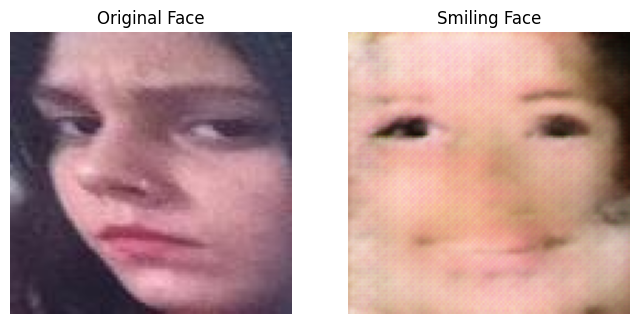

In [71]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tkinter import filedialog
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Load Pretrained Feature Extractor (ResNet-50)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Function to process user-uploaded image
def process_image(image_path):
    """Loads and preprocesses the uploaded image."""
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (128, 128))  # Resize to model input size
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Apply ResNet preprocessing
    return img

# Function to map extracted features to 100-D latent space
def map_features_to_latent(features):
    """Maps (2048,) extracted features to (100,) latent space."""
    flatten_features = tf.keras.layers.GlobalAveragePooling2D()(features)  # Shape (1, 2048)
    latent_vector = tf.keras.layers.Dense(100, activation="relu")(flatten_features)  # Shape (1, 100)
    return latent_vector

# Function to transform face into smiling face
def generate_smiling_face(image_path, generator):
    """Takes a user-uploaded image and generates a smiling face."""
    input_image = process_image(image_path)

    # Extract Features using ResNet-50
    latent_features = feature_extractor.predict(input_image)  # Shape (1, 4, 4, 2048)

    # Map extracted features to 100-D latent space
    latent_vector = map_features_to_latent(latent_features)  # Now shape (1, 100)

    # Create "happy" label (assuming label 3 is "smiling")
    label = tf.one_hot([3], depth=7)  # Adjust based on your dataset

    # Generate smiling face
    generated_image = generator([latent_vector, label], training=False).numpy()
    generated_image = (generated_image + 1) / 2  # Convert back to [0,1] range

    # Plot original vs. generated image
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].imshow(cv2.imread(image_path)[:, :, ::-1])  # Display original image
    ax[0].set_title("Original Face")
    ax[0].axis("off")

    ax[1].imshow(generated_image[0])
    ax[1].set_title("Smiling Face")
    ax[1].axis("off")

    plt.show()

# Function for user to upload an image
def upload_and_generate(generator):
    """Opens file dialog for user to upload an image and generates smiling face."""
    file_path = filedialog.askopenfilename(title="Select an Image",
                                           filetypes=[("Image files", "*.jpg;*.png;*.jpeg")])
    if file_path:
        generate_smiling_face(file_path, generator)

# Run the function
upload_and_generate(generator)
